TO-DO
* verificar se para todos os valores nulos na operation, todos os k_symbol são interested credited
* verificar se a k_symbol acrescenta informação relevante à operation (sem ser os valores nulos corresponderem ao interested credited), visto que esta apenas especifica mais algumas operações
* agrupar withdrawal in cash e withdrawal do type (testar juntos e separados para ver os resultados)
* retirar coluna account - tem muitos valores a zero (verificar, pois poderá ser devido a um erro) (testar primeiro sem valores a zero e depois sem a coluna)
* retirar coluna bank
* provavelmente retirar a coluna type, pois poderá não acrescentar valor aos dados nada de relevante que já não esteja na coluna operation (testar). Coluna type é uma generalização da operation logo apenas simplifica a informação e não acrescenta nada.

In [112]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample

In [113]:
def dataset(x, missing = ""):
    return pd.read_csv('Dataset/' + x + '.csv', sep = ';', low_memory = False, na_values = missing_values).rename(str.strip, axis = 'columns')

In [114]:
missing_values = ['?', 'NA', '']
account_data = dataset('account', missing_values)
client_data = dataset('client', missing_values)
disp_data = dataset('disp', missing_values)
district_data = dataset('district', missing_values)
card_train = dataset('card_train', missing_values)
card_test = dataset('card_test')
loan_train = dataset('loan_train', missing_values)
loan_test = dataset('loan_test')
trans_train = dataset('trans_train', missing_values)
trans_test = dataset('trans_test')

In [115]:
# Removing name and region from district
district_data.drop(['name', 'region'], axis=1, inplace=True)

# only owner can issue permanent orders and ask for a loan
#disp_owners = disp_data[disp_data.type.eq('OWNER')]
#disp_owners.drop(['type'], axis=1, inplace=True)

In [116]:
# Normalize birthday dates and add a new column (Genre) to distinguish

birth_dates = client_data['birth_number']
dates_parsed = []
genre = []
for date in birth_dates:
    month = int(str(date)[2:4])
    if month > 12:
        genre.append(0)
        month = month - 50
        if month < 10:
            month = '0' + str(month)
        else:
            month = str(month)
    else:
        #print('AAAA: ' + str(month))
        if month < 10:
            month = '0' + str(month)
            #print('BBBB: ' + str(month))
        else:
            month = str(month)
        genre.append(1)
    dates_parsed.append(str(date)[:2] + '-' + month + '-' + str(date)[4:])
    
ages = []
for date in dates_parsed:
    born_year = '19' + date[:2]
    age = 2021 - int(born_year)
    ages.append(age)
    
client_data = client_data.drop(['birth_number'], axis = 1)
client_data['age'] = ages
client_data['genre'] = genre
client_data.head()

,client_id,district_id,age,genre
0,1,18,51,0
1,2,1,76,1
2,3,1,81,0
3,4,5,65,1
4,5,5,61,0


In [117]:
# build train dataset

train_data = loan_train
train_data = pd.merge(train_data, trans_train, on = 'account_id', suffixes = ('', '_trans'))
train_data = pd.merge(train_data, account_data, on = 'account_id', suffixes = ('', '_account'))
#train_data = train_data.dropna()
train_data = pd.merge(train_data, district_data.set_index('code'), left_on = 'district_id', right_index = True, suffixes = ('', '_district'))
train_data = pd.merge(train_data, disp_data, on = 'account_id', suffixes = ('', '_disp'))
train_data = pd.merge(train_data, card_train, on = 'disp_id', how = 'outer', suffixes = ('', '_card'))
train_data = pd.merge(train_data, client_data, on = 'client_id', suffixes = ('', '_client'))
train_data = train_data.drop(['district_id_client'], axis=1)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30373 entries, 0 to 30372
Data columns (total 40 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   loan_id                                           30373 non-null  float64
 1   account_id                                        30373 non-null  float64
 2   date                                              30373 non-null  float64
 3   amount                                            30373 non-null  float64
 4   duration                                          30373 non-null  float64
 5   payments                                          30373 non-null  float64
 6   status                                            30373 non-null  float64
 7   trans_id                                          30373 non-null  float64
 8   date_trans                                        30373 non-null  float64
 9   type             

In [118]:
train_data.head()

,loan_id,account_id,date,amount,duration,payments,status,trans_id,date_trans,type,...,no. of commited crimes '95,no. of commited crimes '96,disp_id,client_id,type_disp,card_id,type_card,issued,age,genre
0,5314.0,1787.0,930705.0,96396.0,12.0,8033.0,-1.0,523621.0,930322.0,credit,...,2985.0,2804.0,2166,2166.0,OWNER,NaN,NaN,NaN,74,0
1,5314.0,1787.0,930705.0,96396.0,12.0,8033.0,-1.0,524054.0,930421.0,credit,...,2985.0,2804.0,2166,2166.0,OWNER,NaN,NaN,NaN,74,0
2,5314.0,1787.0,930705.0,96396.0,12.0,8033.0,-1.0,524055.0,930521.0,credit,...,2985.0,2804.0,2166,2166.0,OWNER,NaN,NaN,NaN,74,0
3,5314.0,1787.0,930705.0,96396.0,12.0,8033.0,-1.0,524056.0,930620.0,credit,...,2985.0,2804.0,2166,2166.0,OWNER,NaN,NaN,NaN,74,0
4,6903.0,9337.0,940604.0,52128.0,24.0,2172.0,1.0,2820215.0,930913.0,credit,...,2985.0,2804.0,11189,11497.0,OWNER,NaN,NaN,NaN,62,0


In [119]:
# build test dataset

test_data = loan_test
test_data = pd.merge(test_data, trans_test, on = 'account_id', suffixes = ('', '_trans'))
test_data = pd.merge(test_data, account_data, on = 'account_id', suffixes = ('', '_account'))
test_data = pd.merge(test_data, district_data.set_index('code'), left_on = 'district_id', right_index = True, suffixes = ('', '_district'))
test_data = pd.merge(test_data, disp_data, on = 'account_id', suffixes = ('', '_disp'))
test_data = pd.merge(test_data, card_test, on = 'disp_id', how = 'outer', suffixes = ('', '_card'))
test_data = pd.merge(test_data, client_data, on = 'client_id', suffixes = ('', '_client'))
test_data = test_data.drop(['district_id_client'], axis=1)
test_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 36389 entries, 0 to 36388
Data columns (total 40 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   loan_id                                           36389 non-null  int64  
 1   account_id                                        36389 non-null  int64  
 2   date                                              36389 non-null  int64  
 3   amount                                            36389 non-null  int64  
 4   duration                                          36389 non-null  int64  
 5   payments                                          36389 non-null  int64  
 6   status                                            0 non-null      float64
 7   trans_id                                          36389 non-null  int64  
 8   date_trans                                        36389 non-null  int64  
 9   type             

In [120]:
test_data.head()

,loan_id,account_id,date,amount,duration,payments,status,trans_id,date_trans,type,...,no. of commited crimes '95,no. of commited crimes '96,disp_id,client_id,type_disp,card_id,type_card,issued,age,genre
0,5895,4473,970103,93960,60,1566,NaN,1309867,951009,credit,...,2080.0,2122,5395,5395,OWNER,NaN,NaN,NaN,59,1
1,5895,4473,970103,93960,60,1566,NaN,1309878,951107,credit,...,2080.0,2122,5395,5395,OWNER,NaN,NaN,NaN,59,1
2,5895,4473,970103,93960,60,1566,NaN,1310161,951108,credit,...,2080.0,2122,5395,5395,OWNER,NaN,NaN,NaN,59,1
3,5895,4473,970103,93960,60,1566,NaN,3664951,951130,credit,...,2080.0,2122,5395,5395,OWNER,NaN,NaN,NaN,59,1
4,5895,4473,970103,93960,60,1566,NaN,1309879,951207,credit,...,2080.0,2122,5395,5395,OWNER,NaN,NaN,NaN,59,1


In [121]:
# Remove all dates from data, because only the number doesn't make sense. Probably transform it to age?
train_data.drop(['date', 'date_trans', 'date_account'], axis=1, inplace=True)
test_data.drop(['date', 'date_trans', 'date_account'], axis=1, inplace=True)

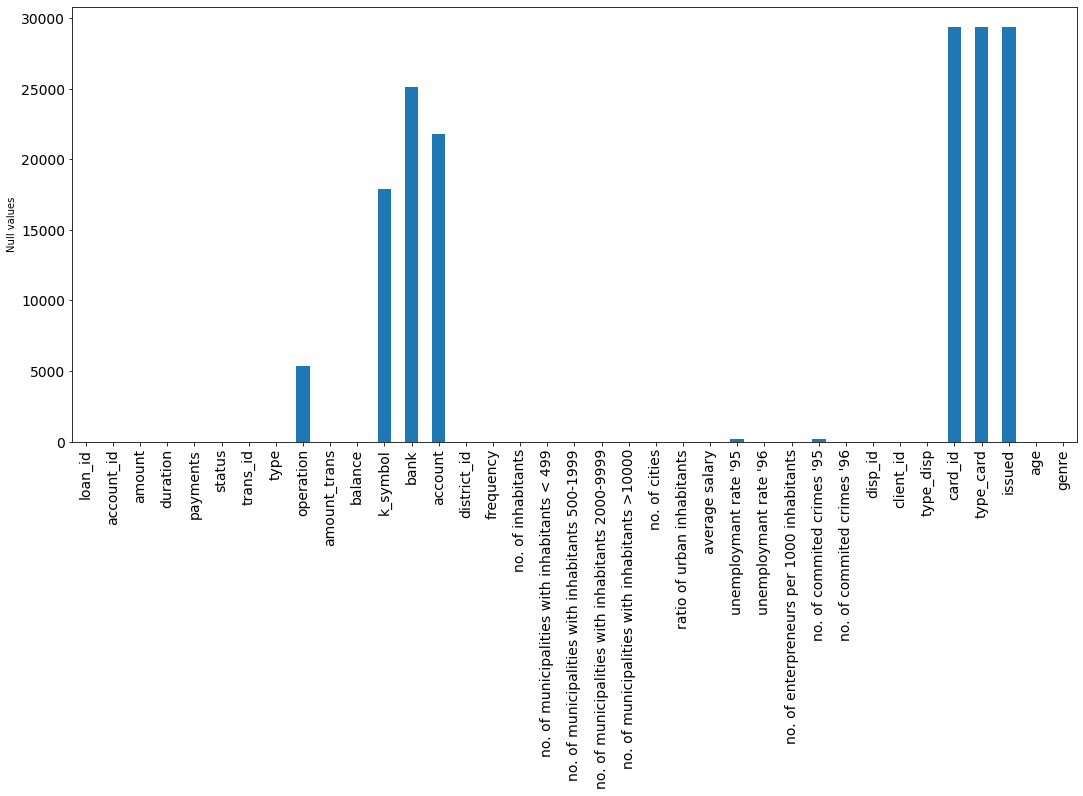

In [122]:
# Null values for each attribute
train_data.isnull().sum().plot(kind='bar', figsize=(18,8), fontsize=14,);
plt.ylabel('Null values');

In [123]:
print('Null values unemploymant rate in \'95:' + str(district_data['unemploymant rate \'95'].isnull().sum()))
print()
print('Null values no. of commited crimes \'95 :' + str(district_data['no. of commited crimes \'95'].isnull().sum()))
print()

Null values unemploymant rate in '95:1

Null values no. of commited crimes '95 :1



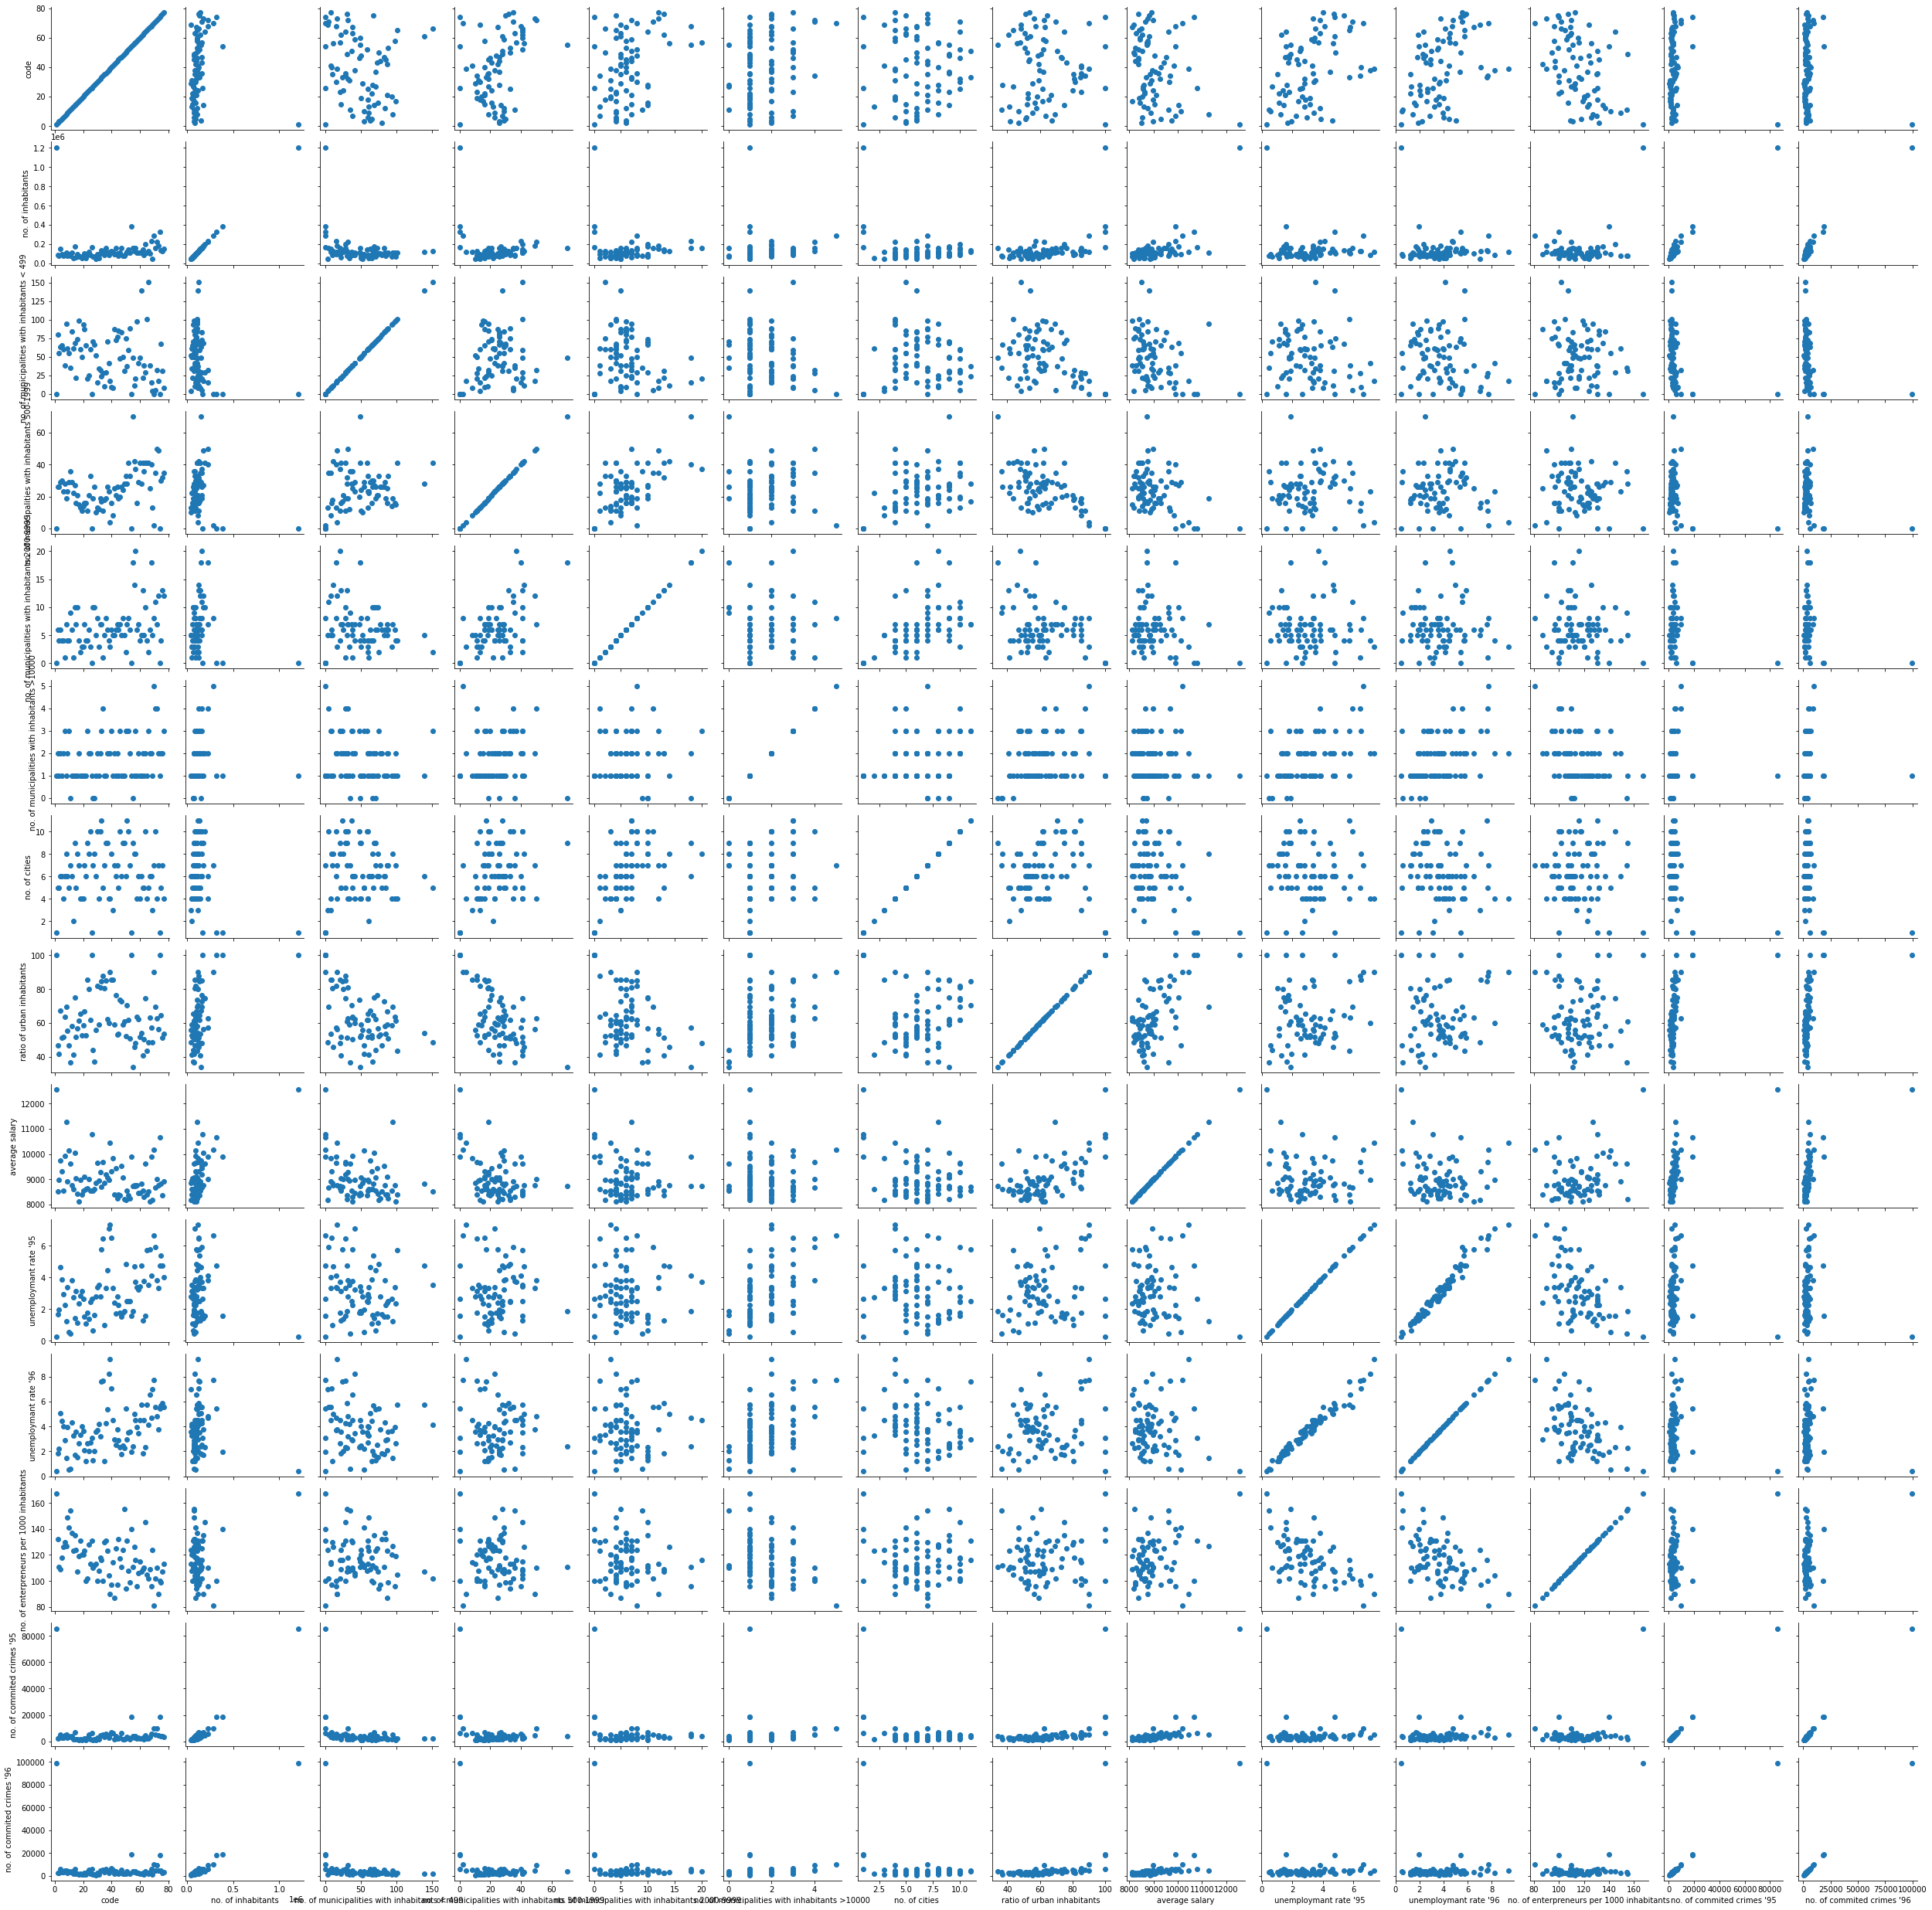

In [124]:
district_scatter_plot = sb.PairGrid(district_data)
district_scatter_plot.map(plt.scatter)

(array([ 4., 13., 10., 13., 15.,  5.,  6.,  4.,  4.,  2.]),
 array([0.29 , 0.995, 1.7  , 2.405, 3.11 , 3.815, 4.52 , 5.225, 5.93 ,
        6.635, 7.34 ]),
 <BarContainer object of 10 artists>)

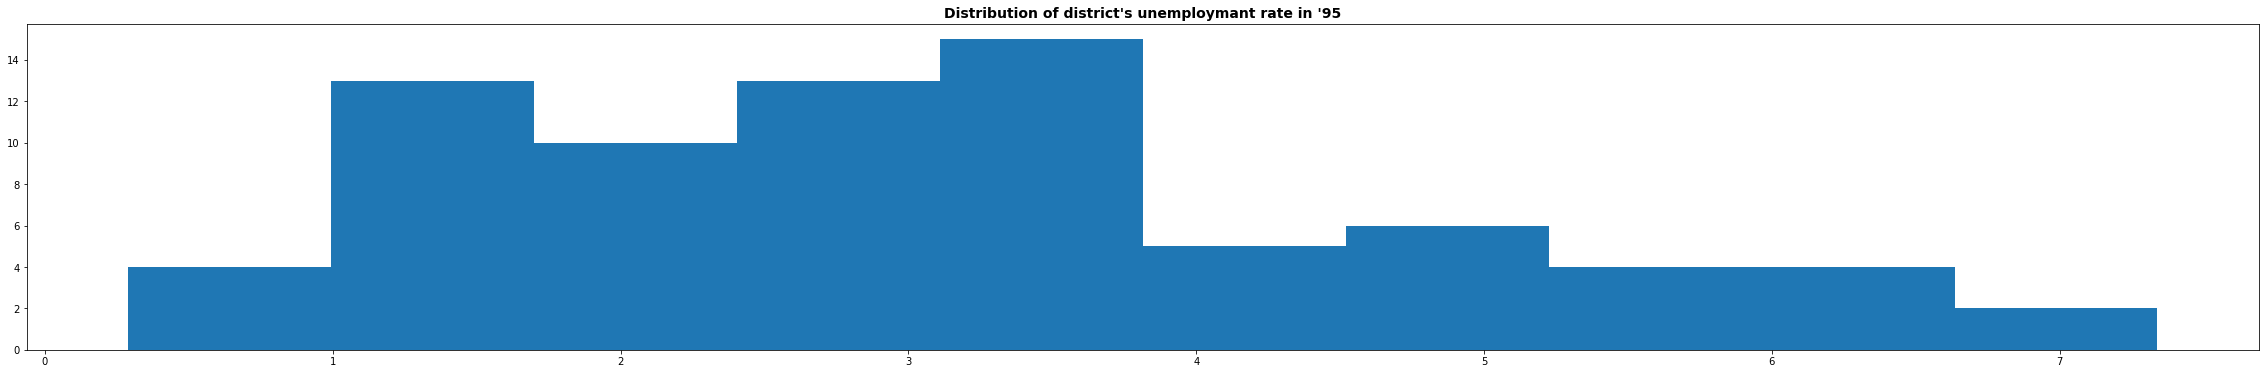

In [125]:
plt.figure(figsize=(40,6))
plt.title('Distribution of district\'s unemploymant rate in \'95', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.hist(district_data['unemploymant rate \'95'])

(array([71.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  818. ,  9303.9, 17789.8, 26275.7, 34761.6, 43247.5, 51733.4,
        60219.3, 68705.2, 77191.1, 85677. ]),
 <BarContainer object of 10 artists>)

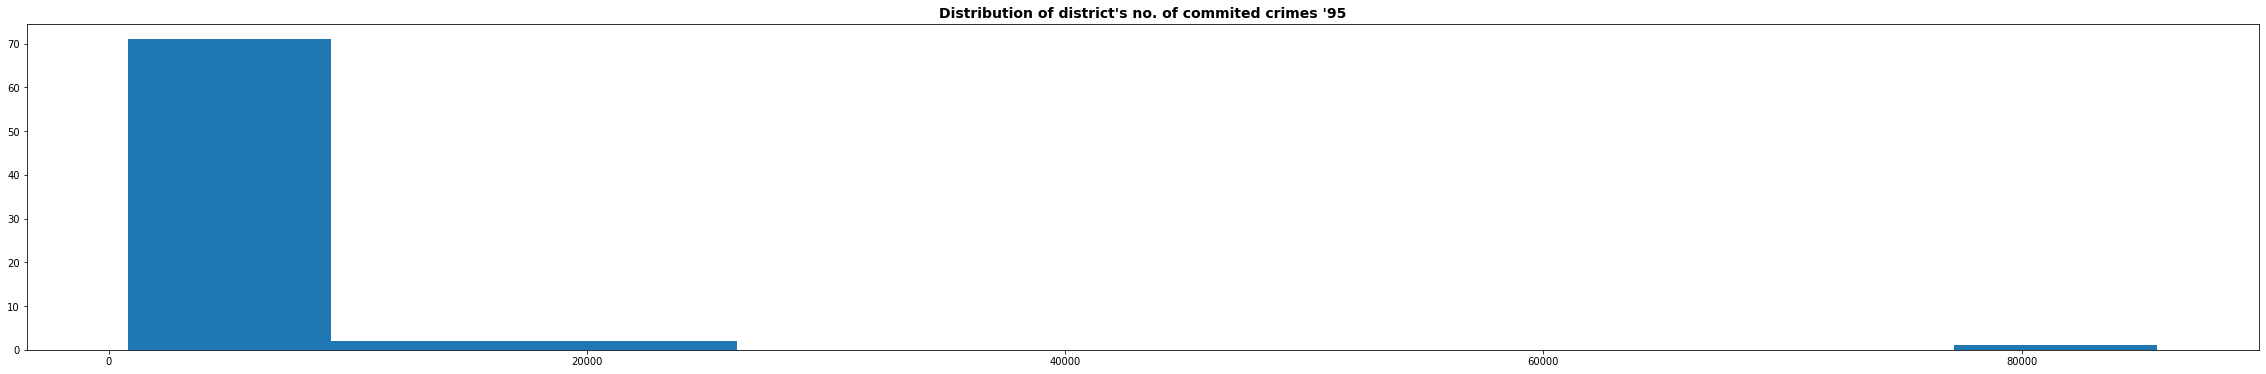

In [126]:
plt.figure(figsize=(40,6))
plt.title('Distribution of district\'s no. of commited crimes \'95', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.hist(district_data['no. of commited crimes \'95'])

In [127]:
# Fill null values in district's unemploymant rate in '95 and district's no. of commited crimes '95

train_data['unemploymant rate \'95'].fillna(train_data['unemploymant rate \'95'].median(), inplace=True)

train_data['no. of commited crimes \'95'].fillna(train_data['no. of commited crimes \'95'].mean(), inplace=True)

In [128]:
print(train_data.operation.value_counts())
print('Null values: ' + str(train_data.operation.isnull().sum()))
print()
print(train_data.k_symbol.value_counts())
print('Null values: ' + str(train_data.k_symbol.isnull().sum()))
print()
print(train_data.bank.value_counts())
print('Null values: ' + str(train_data.bank.isnull().sum()))
print()
print(train_data.type_card.value_counts())
print('Null values: ' + str(train_data.type_card.isnull().sum()))
print()
print(train_data.type.value_counts())
print('Null values: ' + str(train_data.type.isnull().sum()))
print()

withdrawal in cash              14232
credit in cash                   5489
remittance to another bank       3781
collection from another bank     1487
credit card withdrawal             26
Name: operation, dtype: int64
Null values: 5358

interest credited                        5358
payment for statement                    3150
household                                2175
                                         1226
insurrance payment                        504
sanction interest if negative balance      38
Name: k_symbol, dtype: int64
Null values: 17922

EF    544
ST    511
YZ    464
KL    463
AB    436
GH    415
IJ    411
QR    360
UV    354
OP    353
CD    352
WX    326
MN    279
Name: bank, dtype: int64
Null values: 25105

classic    862
gold        99
junior      77
Name: type_card, dtype: int64
Null values: 29335

withdrawal            17043
credit                12334
withdrawal in cash      996
Name: type, dtype: int64
Null values: 0



In [129]:
# needs to be checked
train_data.drop(['bank', 'k_symbol', 'account', 'operation', 'issued'], axis=1, inplace=True)
test_data.drop(['bank', 'k_symbol', 'account', 'operation', 'issued'], axis=1, inplace=True)

In [130]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30373 entries, 0 to 30372
Data columns (total 32 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   loan_id                                           30373 non-null  float64
 1   account_id                                        30373 non-null  float64
 2   amount                                            30373 non-null  float64
 3   duration                                          30373 non-null  float64
 4   payments                                          30373 non-null  float64
 5   status                                            30373 non-null  float64
 6   trans_id                                          30373 non-null  float64
 7   type                                              30373 non-null  object 
 8   amount_trans                                      30373 non-null  float64
 9   balance          

In [131]:
train_data = pd.get_dummies(train_data, columns=['frequency'], dtype=bool)
test_data = pd.get_dummies(test_data, columns=['frequency'], dtype=bool)

train_data = pd.get_dummies(train_data, columns=['type_card'], dtype = bool)
test_data = pd.get_dummies(test_data, columns=['type_card'], dtype = bool)

train_data = pd.get_dummies(train_data, columns=['type_disp'], dtype = bool)
test_data = pd.get_dummies(test_data, columns=['type_disp'], dtype = bool)

train_data = pd.get_dummies(train_data, columns=['type'], dtype = bool)
test_data = pd.get_dummies(test_data, columns=['type'], dtype = bool)

test_data = test_data.drop_duplicates(subset=['loan_id'], keep='first')

#train_data = pd.get_dummies(train_data)
#test_data = pd.get_dummies(test_data)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30373 entries, 0 to 30372
Data columns (total 39 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   loan_id                                           30373 non-null  float64
 1   account_id                                        30373 non-null  float64
 2   amount                                            30373 non-null  float64
 3   duration                                          30373 non-null  float64
 4   payments                                          30373 non-null  float64
 5   status                                            30373 non-null  float64
 6   trans_id                                          30373 non-null  float64
 7   amount_trans                                      30373 non-null  float64
 8   balance                                           30373 non-null  float64
 9   district_id      

In [132]:
train_data.head()

,loan_id,account_id,amount,duration,payments,status,trans_id,amount_trans,balance,district_id,...,frequency_monthly issuance,frequency_weekly issuance,type_card_classic,type_card_gold,type_card_junior,type_disp_DISPONENT,type_disp_OWNER,type_credit,type_withdrawal,type_withdrawal in cash
0,5314.0,1787.0,96396.0,12.0,8033.0,-1.0,523621.0,1100.0,1100.0,30.0,...,False,True,False,False,False,False,True,True,False,False
1,5314.0,1787.0,96396.0,12.0,8033.0,-1.0,524054.0,9900.0,11000.0,30.0,...,False,True,False,False,False,False,True,True,False,False
2,5314.0,1787.0,96396.0,12.0,8033.0,-1.0,524055.0,5800.0,16800.0,30.0,...,False,True,False,False,False,False,True,True,False,False
3,5314.0,1787.0,96396.0,12.0,8033.0,-1.0,524056.0,3300.0,20100.0,30.0,...,False,True,False,False,False,False,True,True,False,False
4,6903.0,9337.0,52128.0,24.0,2172.0,1.0,2820215.0,900.0,900.0,30.0,...,True,False,False,False,False,False,True,True,False,False


In [133]:
competition_inputs = test_data.drop(columns=["loan_id", "status"])
test_data = test_data.drop(columns=["status"])
all_ids_comp = test_data['loan_id'].values

4 Dropped columns: ["unemploymant rate '96", "no. of commited crimes '95", "no. of commited crimes '96", 'type_disp_OWNER']


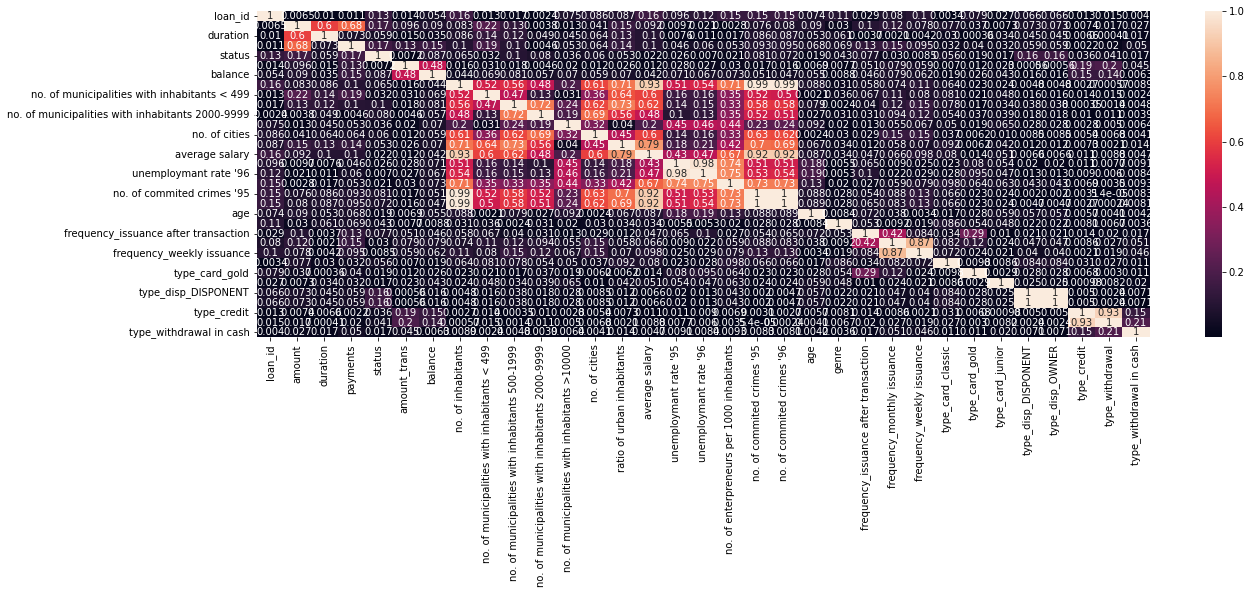

In [134]:
# Dropping ids
#train_data_no_ids = train_data.drop(['loan_id', 'account_id', 'district_id', 'disp_id', 'client_id', 'card_id', 'trans_id'], axis=1)
train_data_no_ids = train_data.drop(['client_id', 'account_id', 'district_id', 'disp_id', 'card_id', 'trans_id'], axis=1)


# Create correlation matrix
corr_matrix = train_data_no_ids.corr().abs()
plt.figure(figsize = (20,6))
sb.heatmap(corr_matrix, annot=True)

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
train_data_no_ids.drop(to_drop, axis=1, inplace=True)

print("{} Dropped columns: {}".format(len(to_drop), to_drop) )

In [135]:
train_data_no_ids.head()

,loan_id,amount,duration,payments,status,amount_trans,balance,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,...,frequency_issuance after transaction,frequency_monthly issuance,frequency_weekly issuance,type_card_classic,type_card_gold,type_card_junior,type_disp_DISPONENT,type_credit,type_withdrawal,type_withdrawal in cash
0,5314.0,96396.0,12.0,8033.0,-1.0,1100.0,1100.0,94812.0,15.0,13.0,...,False,False,True,False,False,False,False,True,False,False
1,5314.0,96396.0,12.0,8033.0,-1.0,9900.0,11000.0,94812.0,15.0,13.0,...,False,False,True,False,False,False,False,True,False,False
2,5314.0,96396.0,12.0,8033.0,-1.0,5800.0,16800.0,94812.0,15.0,13.0,...,False,False,True,False,False,False,False,True,False,False
3,5314.0,96396.0,12.0,8033.0,-1.0,3300.0,20100.0,94812.0,15.0,13.0,...,False,False,True,False,False,False,False,True,False,False
4,6903.0,52128.0,24.0,2172.0,1.0,900.0,900.0,94812.0,15.0,13.0,...,False,True,False,False,False,False,False,True,False,False


In [136]:
# Removing rows with nan values for status
#train_data_no_ids.dropna(subset=["status"], inplace=True)

#print(no_ids.drop_duplicates(inplace=True)
print(train_data_no_ids["status"].value_counts())

 1.0    27403
-1.0     2970
Name: status, dtype: int64


In [137]:
train_data_no_ids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30373 entries, 0 to 30372
Data columns (total 29 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   loan_id                                           30373 non-null  float64
 1   amount                                            30373 non-null  float64
 2   duration                                          30373 non-null  float64
 3   payments                                          30373 non-null  float64
 4   status                                            30373 non-null  float64
 5   amount_trans                                      30373 non-null  float64
 6   balance                                           30373 non-null  float64
 7   no. of inhabitants                                30373 non-null  float64
 8   no. of municipalities with inhabitants < 499      30373 non-null  float64
 9   no. of municipali

In [138]:
train_data_no_ids.head()

,loan_id,amount,duration,payments,status,amount_trans,balance,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,...,frequency_issuance after transaction,frequency_monthly issuance,frequency_weekly issuance,type_card_classic,type_card_gold,type_card_junior,type_disp_DISPONENT,type_credit,type_withdrawal,type_withdrawal in cash
0,5314.0,96396.0,12.0,8033.0,-1.0,1100.0,1100.0,94812.0,15.0,13.0,...,False,False,True,False,False,False,False,True,False,False
1,5314.0,96396.0,12.0,8033.0,-1.0,9900.0,11000.0,94812.0,15.0,13.0,...,False,False,True,False,False,False,False,True,False,False
2,5314.0,96396.0,12.0,8033.0,-1.0,5800.0,16800.0,94812.0,15.0,13.0,...,False,False,True,False,False,False,False,True,False,False
3,5314.0,96396.0,12.0,8033.0,-1.0,3300.0,20100.0,94812.0,15.0,13.0,...,False,False,True,False,False,False,False,True,False,False
4,6903.0,52128.0,24.0,2172.0,1.0,900.0,900.0,94812.0,15.0,13.0,...,False,True,False,False,False,False,False,True,False,False


In [139]:
# Removing labels and creating another dataset for them
train_data_no_ids = train_data_no_ids.dropna()
default_ind_no = train_data_no_ids.loc[train_data_no_ids['status'] == -1]
default_ind_yes = train_data_no_ids.loc[train_data_no_ids['status'] == 1]

df_minority_upsampled = resample(default_ind_yes, replace=True, n_samples=len(default_ind_no),random_state=123)

train_data_no_ids = pd.concat([default_ind_no, df_minority_upsampled])

train_data_no_ids.status.value_counts()


-1.0    2970
 1.0    2970
Name: status, dtype: int64

In [140]:
all_inputs = train_data_no_ids[train_data_no_ids.columns.drop(['loan_id'])]
all_labels = train_data_no_ids['status'].values

competition_inputs = test_data.drop(columns=["loan_id"])
all_ids_comp = test_data['loan_id'].values

#all_inputs = train_data_no_ids.iloc[:, :-1].values
#all_labels = train_data_no_ids.iloc[:, -1].values

In [141]:
all_inputs.status.value_counts()

-1.0    2970
 1.0    2970
Name: status, dtype: int64

In [142]:
# get a test dataset with 25% of the credit_data_subset
(X_train, X_test, y_train, y_test) = train_test_split(all_inputs, all_labels, test_size=0.25, random_state=1)
#(X_train, X_test, y_train, y_test) = train_test_split(all_inputs, all_labels, random_state=1)

In [143]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4455 entries, 30330 to 15426
Data columns (total 28 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   amount                                            4455 non-null   float64
 1   duration                                          4455 non-null   float64
 2   payments                                          4455 non-null   float64
 3   status                                            4455 non-null   float64
 4   amount_trans                                      4455 non-null   float64
 5   balance                                           4455 non-null   float64
 6   no. of inhabitants                                4455 non-null   float64
 7   no. of municipalities with inhabitants < 499      4455 non-null   float64
 8   no. of municipalities with inhabitants 500-1999   4455 non-null   float64
 9   no. of municip

Classification report:
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00       751
         1.0       1.00      1.00      1.00       734

    accuracy                           1.00      1485
   macro avg       1.00      1.00      1.00      1485
weighted avg       1.00      1.00      1.00      1485




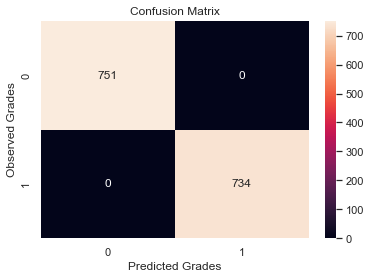

In [144]:
# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
decision_tree_classifier.fit(X_train, y_train)

dtc_prediction = decision_tree_classifier.predict(X_test)

dtc_classification_report = classification_report(y_test, dtc_prediction, output_dict=True)

print(f"Classification report:\n{classification_report(y_test, dtc_prediction)}\n")

sb.set(font_scale=1.0)

ax = plt.subplot()

confusion_matrix_dtc = confusion_matrix(y_test, dtc_prediction)

sb.heatmap(confusion_matrix_dtc, annot=True, ax=ax, fmt="g")

ax.set_xlabel('Predicted Grades');
ax.set_ylabel('Observed Grades');
ax.set_title('Confusion Matrix');
plt.show()